In [98]:
import numpy as np
import torch
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
# from torchsummary import summary
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import torch.nn as nn
from sklearn.metrics import matthews_corrcoef
import warnings
from sklearn import metrics
import torch.nn.init as init
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNetCV
# from operator import itemgetter
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
# from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.base import clone
from rdkit import Chem
from collections import defaultdict

In [103]:
df = pd.read_csv("data/train_raw_data.csv",index_col=0)
positive_indices = np.where(df["Toxicity"] == 1)[0]
negative_indices = np.where(df["Toxicity"] == 0)[0]

positive_samples = np.array(df["Inchi"])[positive_indices]
negative_samples = np.array(df["Inchi"])[negative_indices]
print(len(positive_indices),len(negative_indices))

1542 5968


In [106]:
# 假設 toxic_mols 和 non_toxic_mols 是兩個分子的列表
# 你需要用你自己的數據去初始化它們


In [113]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from collections import defaultdict

# Get ring substructures of a given size from a molecule
def get_ring_substructs(mol, min_size=3, max_size=15):
    ring_substructs = []
    for size in range(min_size, max_size+1):
        ssr = Chem.GetSymmSSSR(mol)
        for ring in ssr:
            if len(ring) == size:
                ring_substructs.append(Chem.MolFragmentToSmiles(mol, ring, canonical=True))
    return ring_substructs
tox_freq = defaultdict(list)
# Count frequency of each substructure in a list of molecules
def count_substructs(mols):
    substruct_freq = defaultdict(int)
    for mol in mols:
        for substruct in get_ring_substructs(mol):
            substruct_freq[substruct] += 1
            tox_freq[substruct].append(mol)
    return substruct_freq

# Get substructures that appear in toxic mols but not in non-toxic mols
def get_toxic_specific_substructs(toxic_mols, non_toxic_mols, min_freq=5):
    toxic_substruct_freq = count_substructs(toxic_mols)
    non_toxic_substruct_freq = count_substructs(non_toxic_mols)
    toxic_specific_substructs = {s for s, f in toxic_substruct_freq.items() if f >= min_freq and s not in non_toxic_substruct_freq}
    return toxic_specific_substructs

# Find toxic-specific substructures in your datasets
toxic_mols = [Chem.MolFromInchi(inchi) for inchi in positive_samples]
non_toxic_mols = [Chem.MolFromInchi(inchi) for inchi in negative_samples]
toxic_specific_substructs = get_toxic_specific_substructs(toxic_mols, non_toxic_mols)

print(len(toxic_specific_substructs))

[14:33:51] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match)

[14:33:51] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[14:33:51] WARNING: not removing hydrogen atom without neighbors
[14:33:51] WARNING: not removing hydrogen atom without neighbors


3


In [114]:
toxic_specific_substructs

{'C1=CCOCC1', 'C1N=CCS1', 'C1ccSNC1'}

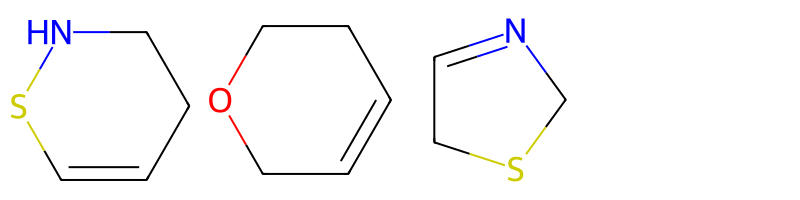

In [115]:
from rdkit.Chem import Draw

# Convert SMILES to molecules
toxic_substruct_mols = [Chem.MolFromSmiles(s) for s in toxic_specific_substructs]

# Draw molecules
img = Draw.MolsToGridImage(toxic_substruct_mols, molsPerRow=4, subImgSize=(200,200))
img


In [116]:
final  = defaultdict(list)
for atom in toxic_specific_substructs:
    print(atom,":")
    for structure in tox_freq[atom]:
        print(Chem.MolToSmiles(structure))

C1ccSNC1 :
CN1C(C(O)=Nc2ccccn2)C(=O)c2ccccc2S1(=O)=O
CN1C(C(O)=Nc2ccccn2)C(=O)c2sccc2S1(=O)=O
CN1C(C(O)=Nc2ccccn2)C(=O)c2sc(Cl)cc2S1(=O)=O
Cc1cc(=NC(=O)C2C(=O)c3ccccc3S(=O)(=O)N2C)[nH]o1
Cc1cnc(N=C(O)C2C(=O)c3ccccc3S(=O)(=O)N2C)s1
C1=CCOCC1 :
CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(OC4CC(OC)C(N=C(C)O)C(C)O4)C(C)O3)C(C)C=CC=C3COC4C(O)C(C)=CC(C(=O)O1)C34O)O2
CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(OC4CC(OC)C(O)C(C)O4)C(C)O3)C(C)C=CC=C3COC4C(O)C(C)=CC(C(=O)O1)C34O)O2
COC1CC(OC2C(C)OC(OC3C(C)=CCC4CC(CC5(C=CC(C)C(C6CCCCC6)O5)O4)OC(=O)C4C=C(C)C(O)C5OCC(=CC=CC3C)C45O)CC2OC)OC(C)C1O
CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(OC4CC(OC)C(NC)C(C)O4)C(C)O3)C(C)C=CC=C3COC4C(O)C(C)=CC(C(=O)O1)C34O)O2.O=C(O)c1ccccc1
C=C(C)C1C(=O)c2c3c(cc4c5c(n1c24)C1(C)C(CCC2C(C)(C=CC=C(C)C(=O)O)C(O)CCC21C)C5)C1=CC(C)(C)OC(C)(C)C1C3O
C1N=CCS1 :
Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)N=C3O)cc1)O2
CN(CCOc1ccc(CC2SC(=O)N=C2O)cc1)c1ccccn1
CC1(COc2ccc(CC3SC(=O)N=C3O)cc2)CCCCC1
CN(CCOc1ccc(CC2SC(=O)N=C2O)cc

In [110]:
# def get_mols_with_substruct(mols, substructs):
#     mols_with_substructs = defaultdict(list)
#     for substruct in substructs:
#         substruct_mol = Chem.MolFromSmiles(substruct)  # Convert the substructure to a RDKit mol object
#         for i, mol in enumerate(mols):
#             if mol.HasSubstructMatch(substruct_mol):  # Check if the molecule contains the substructure
#                 mols_with_substructs[substruct].append(i)  # If so, add the molecule to the list
#     return mols_with_substructs

# # Use the function on your toxic mols
# x = [Chem.MolFromInchi(s) for s in positive_samples]
# toxic_mols_with_substructs = get_mols_with_substruct(x, toxic_specific_substructs)


In [111]:
# toxic_mols_with_substructs

In [112]:
# for i, mol in enumerate(x):
#     if mol.HasSubstructMatch(Chem.MolFromSmiles('C1ccSNC1')):  # Check if the molecule contains the substructure
#         print(i)